In [1]:
import numpy as np
import pandas as pd
import pickle
from glob import glob
import re

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
folder = "./"

In [4]:
# Progress tracker from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

### Processing test data

In [4]:
test_df = pd.read_csv('test_sessions.csv', index_col='session_id', \
                      parse_dates=[2,4,6,8,10,12,14,16,18,20], \
                      infer_datetime_format=True)

In [5]:
len(test_df)

46473

In [14]:
with open("site_dic.pkl") as pkl:
    site_dic = pickle.load(pkl)

In [7]:
id_site_dic = {}
for k, v in site_dic.items():
    id_site_dic[v] = k

In [8]:
data = []
for session in test_df.values:
    for i in range (0, 20, 2):
        if str(session[i]) != 'nan':
            row = [session[i+1], id_site_dic[int(session[i])]]
            data.append(row)
data = pd.DataFrame(data, columns=["timestamp", "site"])

In [9]:
data.to_csv("full_test_temp.csv", index=False)

### Preparing sessions with features

In [5]:
def sitefreq(sites, site_freq={}, site_index={}):
    if not len(site_index):
        if len(site_freq):
            site_id = max(site_freq.items(), key=lambda t: t[1][0])[1][0] + 1
        else:
            site_id = 1
    for site in sites:
        if len(site_index):
            site_id = site_index[site]
                
        if site not in site_freq:
            site_freq[site] = [site_id, 1]
            site_id += 1
        else:
            site_freq[site][1] += 1
            
    return site_freq

In [6]:
def prepare_train_set_with_fe(csv_files_mask, feature_names, site_index={}, site_freq_path="", dataframe_csv="",
                                    session_length=10, window_size=10, session_time = 30,\
                                sort_in_session=False,
                             freq_only=False, prediction=False, remove_dups=True):
    
    global_window_size = window_size
    train_data = np.array([np.zeros(len(feature_names))])
    site_freq = {}
    session_num = 0
    temp_session_length = session_length
    user_count = 1
    
    if site_freq_path != "":
        pkl_file = open(site_freq_path, 'rb')
        site_freq = pickle.load(pkl_file)
    
    if len(site_freq):
        regex=re.compile(".*(facebook).*")
        facebook_ix = [site_freq[i][0] for i in [m.group(0) for l in site_freq.keys() for m in [regex.search(l)] if m]]
        regex=re.compile(".*(youtube).*")
        youtube_ix = [site_freq[i][0] for i in [m.group(0) for l in site_freq.keys() for m in [regex.search(l)] if m]]

        num_more_100 = len([[k, v] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=False) if v[1] > 1000])
        top30_ix = [v[0] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:num_more_100]]
        num_less_100 = len([[k, v] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=False) if v[1] < 50])
        bot30_ix = [v[0] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=False)[:num_less_100]]
    else:
        freq_only = True
        print "Building site freq."
    
    data = None
    if dataframe_csv != "":
        data = pd.read_csv(dataframe_csv, parse_dates=[0], infer_datetime_format=True)
        files = [0]
    else:
        files = glob(csv_files_mask)
        
    for userfile in log_progress(files, every=1):
        if dataframe_csv == "":
            window_size = global_window_size
            user_id = int(re.search('user(\d+)\.csv', userfile).group(1))
            data = pd.read_csv(userfile, \
                               parse_dates=[0], infer_datetime_format=True)
            #if user_id == "3165":
                #data = data.sample(int(len(data)/2))
            if not len(data):
                continue
            data.sort_values("timestamp", inplace=True)
            data.reset_index(drop=True, inplace=True)
            
            user_count += 1
        session_hash = {}    
        
        if freq_only: site_freq = sitefreq(data.site, site_freq, site_index)
            
        if not freq_only:
        
            session = []
            timestamps = []
            next_session = []
            next_t_session = []
            next_s_session = []
            next_timestamps = []

            for i in range (0, len(data), window_size):  
                session += list(data[i:i+session_length].site.apply(lambda x: site_index[x]))
                timestamps += list(data[i:i+session_length].timestamp)

                if window_size < session_length and sort_in_session:
                    ses_ts_zip = sorted(set(zip(session, timestamps)), key = lambda t: t[1])
                    session, timestamps = zip(*ses_ts_zip)
                    session = list(session)
                    timestamps = list(timestamps)

                while ((len(session) >= session_length) or (not len(data[i+window_size:]) and len(session))):
                    time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                    session_timespan = (max(timestamps) - min(timestamps)).total_seconds()
                    next_session = []
                    next_timestamps = []
                    
                    while session_timespan > session_time*60 or len(session) > session_length:
                        next_session.insert(0, session.pop())
                        next_timestamps.insert(0, timestamps.pop())
                        time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                        session_timespan = (max(timestamps) - min(timestamps)).total_seconds()

                    session = tuple(session)

                    if session not in session_hash or dataframe_csv != "" or not remove_dups:                      
                        session_hash[session] = 1
                        session = list(session)                       
                                                
                        if dataframe_csv != "" and sort_in_session: #need to sort sites in sessions by timestamp in test data
                            ses_ts_zip = sorted(set(zip(session, timestamps)), key = lambda t: t[1])
                            session, timestamps = zip(*ses_ts_zip)
                            session = list(session)
                            timestamps = list(timestamps)
                            time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                            session_timespan = (max(timestamps) - min(timestamps)).total_seconds()
                        
                        num_unique_sites = len(set(session))
                        start_hour = min(timestamps).hour
                        day_of_week = min(timestamps).weekday()
                        
                        #сайт, на котором пользователь находился дольше всего в сессии
                        if len(session) == 1:
                            site_longest_time = session[0]
                        else:
                            site_longest_time = session[time_diff.index(max(time_diff))]
                        
                        #доля facebook в сессии по времени
                        facebook_in_session = np.where(np.in1d(session, facebook_ix) == True)[0]
                        facebook_times = [time_diff[t] for t in facebook_in_session if t < len(time_diff)]
                        fb_portion = sum(facebook_times)/session_timespan if len(facebook_times) and session_timespan else 0
                        #print(facebook_in_session)

                        #доля youtube в сессии по времени
                        youtube_in_session = np.where(np.in1d(session, youtube_ix) == True)[0]
                        youtube_times = [time_diff[t] for t in youtube_in_session if t < len(time_diff)]
                        youtube_portion = sum(youtube_times)/session_timespan if len(youtube_times) and session_timespan else 0

                        #доля топ30 сайтов в сессии по времени
                        top30_in_session = np.where(np.in1d(session, top30_ix) == True)[0]
                        top30_times = [time_diff[t] for t in top30_in_session if t < len(time_diff)]
                        top30_portion = sum(top30_times)/session_timespan if len(top30_times) and session_timespan else 0
                        
                        #доля бот30 сайтов в сессии по времени
                        bot30_in_session = np.where(np.in1d(session, bot30_ix) == True)[0]
                        bot30_times = [time_diff[t] for t in bot30_in_session if t < len(time_diff)]
                        bot30_portion = sum(bot30_times)/session_timespan if len(bot30_times) and session_timespan else 0

                        #время суток начала сессии: 5-12 утро, 12-17 - день, 18-23 вечер, 0-5 ночь
                        if start_hour in range(5,12):
                            daytime = 0
                        elif start_hour in range(12, 18):
                            daytime = 1
                        elif start_hour > 18:
                            daytime = 2
                        elif start_hour < 5:
                            daytime = 3
                            
                        if dataframe_csv != "":
                            session_length = temp_session_length
                            

                        session_prediction = 0
                        if prediction:
                            for site in session:
                                if site in site_user_dic and len(site_user_dic[site]) == 1:
                                    session_prediction = list(site_user_dic[site])[0]
                                    break   

                        session.extend([0] * (session_length - len(session)) + \
                                       timestamps + [0] * (session_length - len(timestamps)) + \
                                       time_diff + \
                                       [0]*(session_length - len(time_diff) - 1) + \
                                       [session_timespan, num_unique_sites, site_longest_time, start_hour, day_of_week, daytime, fb_portion,\
                                youtube_portion, top30_portion, bot30_portion, session_prediction])
                        if dataframe_csv == "":
                            session.extend([user_id])
                        

                        train_data = np.concatenate((train_data, np.array([session])))
                        session_num += 1

                    session = next_session
                    timestamps = next_timestamps
            
            if len(next_session):
                print("ERROR! next_session left!")
                print(session)
                return None

    if freq_only:
        with open('site_freq.pkl', 'wb') as site_freq_pkl:
            pickle.dump(site_freq, site_freq_pkl)
        return site_freq
    
    train_data = np.delete(train_data, 0, 0)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    return train_data

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + ['time' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'site_longest_time', 'start_hour', 'day_of_week', 'daytime', 'fb_portion',\
                 'youtube_portion', 'top30_portion', 'bot30_portion', 'prediction', 'target']

In [38]:
%%time
site_freq  = prepare_train_set_with_fe('train/*',
                                   feature_names=feature_names, 
                                            freq_only=True, site_index = site_dic, session_length=10)

Building site freq.
CPU times: user 4.73 s, sys: 92 ms, total: 4.82 s
Wall time: 4.66 s


In [39]:
freqs = [v[1] for v in site_freq.values() if v[1] >1050]
print min(freqs), max(freqs), np.mean(freqs), np.median(freqs)

1054 80499 5930.00505051 2203.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6503fd7c50>]], dtype=object)

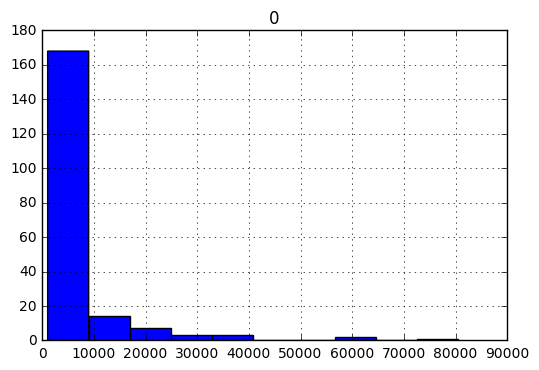

In [15]:
pd.DataFrame(freqs).hist()

In [52]:
train_data_initial = pd.read_csv("train_sessions.csv", index_col="session_id").fillna(0)

In [8]:
pkl_file = open("site_freq.pkl", 'rb')
site_freq = pickle.load(pkl_file)

In [17]:
%%time
user_site_dic = {}
site_user_dic = {}

print "Rows:", len(train_data_initial)
for i, v in train_data_initial.iterrows():
    userid = int(v.user_id)
    if userid not in user_site_dic:
        user_site_dic[userid] = {}
    for site in ['site' + str(i) for i in range(1,11)]:
        ssite = int(v[site])
        if ssite != 0:
            if ssite in user_site_dic[userid]:
                user_site_dic[userid][ssite] +=1
            else:
                user_site_dic[userid][ssite] = 1
        
        if ssite in site_user_dic:
            site_user_dic[ssite].add(userid)
        else:
            site_user_dic[ssite] = set([userid])

Rows: 182793
CPU times: user 29.4 s, sys: 88 ms, total: 29.5 s
Wall time: 29.4 s


In [15]:
%%time
train_data  = prepare_train_set_with_fe('train/*',
                                feature_names=feature_names, site_index = site_dic, \
                                site_freq_path="site_freq.pkl", session_length=10, prediction=False,\
                                remove_dups=False)

CPU times: user 2h 4min 50s, sys: 5min 34s, total: 2h 10min 25s
Wall time: 2h 10min 23s


In [35]:
%%time
test_feature_names = feature_names[:-1]
test_data  = prepare_train_set_with_fe('train/*', dataframe_csv="full_test_temp.csv",
                                feature_names=test_feature_names, site_index = site_dic, \
                                site_freq_path="site_freq.pkl", session_length=10, \
                                prediction=True, sort_in_session=True)

CPU times: user 11min 33s, sys: 196 ms, total: 11min 34s
Wall time: 11min 33s


In [17]:
#test_data.to_csv(folder+"full_test.csv", index=False)
train_data.to_csv(folder+"full_train.csv", index=False)

# Vowpal Wabbit

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools
from sklearn.decomposition import NMF, TruncatedSVD

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack, vstack
import imblearn
from glob import glob
from gensim.models import Word2Vec
from gensim.models import Phrases

In [8]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]


def sites_to_sparse_tfidf(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
    test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

    y = train_data[target_col]

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
    train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                                  for i in range(train_test_df_sites.shape[0])]

    tfidf = TfidfVectorizer(max_df=0.9).fit(train_test_df_sites_array) #TfidfVectorizer()
    X_train_test_sparse = tfidf.transform(train_test_df_sites_array)

    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, \
             train_duplicates_mask, test_duplicates_mask]


def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix


def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse


def combine_sites_features_sparse(sites_train_sparse, train_valid_seq_sparse, features_train_sparse, \
                                  sites_test_sparse, test_seq_sparse, features_test_sparse, \
                                  train_duplicates_mask = None, test_duplicates_mask = None, \
                                  train_site_times_sparse = None, test_site_times_sparse = None, \
                                train_sites_sequence=None, test_sites_sequence=None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse, train_preds_sparse,\
                                 train_site_times_sparse, train_sites_sequence], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse, test_preds_sparse,\
                                test_site_times_sparse, test_sites_sequence], dtype=float).tocsr()
    #else:
        #X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
        #X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
        
    X_train_sparse = hstack([sites_train_sparse, train_valid_seq_sparse, features_train_sparse], dtype=float).tocsr()
    X_test_sparse = hstack([sites_test_sparse, test_seq_sparse, features_test_sparse], dtype=float).tocsr()
    return [X_train_sparse, X_test_sparse]


def sparse_matrix_to_vw(X_sparse, sites_columns_num, num_vec_comp, num_seqs, vocabulary, \
                        y=None, weights=None, mark_duplicates=False, mycolumns=[], add_features=True):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    sequence = {}
    vector = {}
    year = {}
    month = {}
    day = {}
    
    lables = {}
    lable_weights = {}
    
    #X_sparse = X_sparse_full[:,:-1]

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if add_features:
                if c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("prediction"):
                    prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                    continue
                elif "year" in mycolumns and c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("year"):
                    year[r] = " |xyear {}".format(int(X_sparse[r,c]))
                    continue
                elif "month" in mycolumns and c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("month"):
                    month[r] = " |wmonth {}".format(int(X_sparse[r,c]))
                    continue
                elif "day" in mycolumns and c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("day"):
                    day[r] = " |vday {}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("day_of_week"):
                    day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                    #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("start_hour"):
                    start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                    #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("daytime"):
                    daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                    #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("session_timespan"):
                    session_timespan[r] = " |jsession_timespan time:{}".format(math.log(X_sparse[r,c]))
                    #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("#unique_sites"):
                    unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                    #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("site_longest_time"):
                    site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                    #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("top30_portion"):
                    top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) + mycolumns.index("bot30_portion"):
                    bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns)+ mycolumns.index("fb_portion"):
                    fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns)+ mycolumns.index("youtube_portion"):
                    youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                    continue
                    
            if c < sites_columns_num:
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                else:
                    if y is not None:
                        sessions[r] = ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                        lables[r] = str(y[r])
                        if weights is not None:
                            lable_weights[r] = str(weights[y[r]-1])
                    else:
                        sessions[r] = ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
            elif c >= sites_columns_num and c < sites_columns_num + num_seqs:
                if r in sequence:
                    sequence[r] += " {}:{}".format(int(c - sites_columns_num), X_sparse[r,c])
                else:
                    sequence[r] = ' |usequence' + " {}:{}".format(int(c - sites_columns_num), X_sparse[r,c])
            #elif c >= sites_columns_num and c < sites_columns_num + num_vec_comp:
                #if r in vector:
                    #vector[r] += " {}:{}".format(int(c - sites_columns_num), X_sparse[r,c])
                #else:
                    #vector[r] = ' |yvector' + " {}:{}".format(int(c - sites_columns_num), X_sparse[r,c])
            #elif c > X_sparse.shape[1] - sites_columns_num and c < X_sparse.shape[1] - 10:
                #if r in sitetimes:
                    #sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                #else:
                    #sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "lables": lables, "lable_weights": lable_weights, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes, "sequence": sequence, "vector": vector, \
                       "year": year, "month": month, "day": day}



def vw_to_file(sites, out_file, features={}, lables={}, lable_weights={},  quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        if r in lables:
            final_vw[r] = lables[r]
        else:
            final_vw[r] = ""
        if r in lable_weights:
            final_vw[r] += " {}".format(lable_weights[r])
    
        final_vw[r] += sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        

        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()
    
    
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)



In [9]:
def create_user_site_dic(train_data, site_freq_pkl):
    user_dic = {}
    site_dic = {}

    pkl_file = open(site_freq_pkl, 'rb')
    site_freq = pickle.load(pkl_file)
    #top_sites = [v[1] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:0]]
    
    for i, v in train_data.iterrows():
        if v.target not in user_dic:
            user_dic[v.target] = {}
        for site in ['site' + str(i) for i in range(1,11)]:
            if int(v[site]) != 0: #and v[site] not in top_sites:
                if v[site] in user_dic[v.target]:
                    user_dic[v.target][v[site]] +=1
                else:
                    user_dic[v.target][v[site]] = 1

                if v[site] in site_dic:
                    site_dic[v[site]].add(v.target)
                else:
                    site_dic[v[site]] = set([v.target])
    
    return user_dic, site_dic

In [10]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    dub = []
    for word in words:
        if len(dub) == 2:
            pair = "_".join(dub)
            if pair in index2word_set:
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[pair])
        else: 
            if word in index2word_set: 
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[word])

        if len(dub) < 2:
            dub.append(word)
        elif len(dub) == 2:
            dub[0] = dub[1]
            dub[1] = word
    # 
    # Divide the result by the number of words to get the average
    if nwords == 0: nwords += 1
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if counter%10000. == 0.:
            print "Item %d of %d" % (counter, len(reviews))
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, \
           num_features)
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [11]:
def assign_sequences(data, seq_id_weight_dic):
    df_sites = data[['site' + str(c) for c in range(1,10+1)]].astype(int)
    data["sequence"] = ""
    for r in log_progress(range(len(df_sites)), every=1):
        session = df_sites.iloc[r].as_matrix().astype(str)
        session = np.delete(session, np.where(session.astype(str) == "0")[0])

        ses_seq = []

        ses_seq_set = set()


        it = np.nditer(session, flags=['f_index'])
        while not it.finished:
            #ses_seq_set.add(tuple([str(it[0])]))
            asession = session[it.index+1:].copy()
            if len(asession) > 0:      
                ita = np.nditer(asession, flags=['f_index'])
                while not ita.finished:
                    ses_seq_set.add(tuple([str(it[0]), str(ita[0])]))
                    bsession = asession[ita.index+1:]
                    if len(bsession) > 0:
                        itb = np.nditer(bsession, flags=['f_index'])
                        while not itb.finished:
                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0])]))
                            csession = bsession[itb.index+1:]
                            if len(csession) > 0:
                                itc = np.nditer(csession, flags=['f_index'])
                                while not itc.finished:
                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0])]))
                                    dsession = csession[itc.index+1:]
                                    if len(dsession) > 0:
                                        itd = np.nditer(dsession, flags=['f_index'])
                                        while not itd.finished:
                                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0])]))
                                            esession = dsession[itd.index+1:]
                                            if len(esession) > 0:
                                                ite = np.nditer(esession, flags=['f_index'])
                                                while not ite.finished:
                                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0])]))
                                                    fsession = esession[ite.index+1:]
                                                    if len(fsession) > 0:
                                                        itf = np.nditer(fsession, flags=['f_index'])
                                                        while not itf.finished:
                                                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0]), str(itf[0])]))
                                                            gsession = fsession[itf.index+1:]
                                                            if len(gsession) > 0:
                                                                itg = np.nditer(gsession, flags=['f_index'])
                                                                while not itg.finished:
                                                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0]), str(itf[0]), str(itg[0])]))
                                                                    itg.iternext()
                                                            itf.iternext()
                                                    ite.iternext()
                                            itd.iternext()
                                    itc.iternext()
                            itb.iternext()
                    ita.iternext()
            it.iternext()

        for seq in ses_seq_set:
            if seq in seq_id_weight_dic:
                ses_seq.append(str(seq_id_weight_dic[seq]['id']))

        if len(ses_seq):
            data.set_value(r, -1, ",".join(ses_seq), takeable=True)

## Let's Start

In [12]:
%%time
#1
train_data = pd.read_csv(folder+'full_train.csv', parse_dates=range(10,21), infer_datetime_format=True)
test_data = pd.read_csv(folder+'full_test.csv', parse_dates=range(10,21), infer_datetime_format=True)

CPU times: user 3.94 s, sys: 264 ms, total: 4.2 s
Wall time: 5.02 s


#### Apply sequences

In [13]:
%%time
with open("seq_id_weight_dic_new.pkl", 'rb') as pkl:
    seq_id_weight_dic = pickle.load(pkl)

CPU times: user 1min 28s, sys: 3.28 s, total: 1min 31s
Wall time: 1min 31s


In [14]:
%%time
seq_id = {}
for seq, d in seq_id_weight_dic.items():
    seq_id[d["id"]] = seq

CPU times: user 10.8 s, sys: 172 ms, total: 11 s
Wall time: 11 s


In [15]:
%%time
seq_weight = {}
for seq, d in seq_id_weight_dic.items():
    seq_weight[d["id"]] = d["w"]

CPU times: user 7.82 s, sys: 184 ms, total: 8.01 s
Wall time: 8.01 s


In [16]:
num_seqs = len(seq_weight.keys())

In [18]:
%%time
assign_sequences(train_data, seq_id_weight_dic)

CPU times: user 58min 39s, sys: 19min 31s, total: 1h 18min 11s
Wall time: 54min 55s


In [19]:
float(len(train_data[train_data.sequence != ""]))/len(train_data)

0.39730733671420676

In [110]:
#train_data = pd.DataFrame(train_data[train_data.sequence != ""]).reset_index(drop=True)

In [20]:
%%time
assign_sequences(test_data, seq_id_weight_dic)

CPU times: user 14min 40s, sys: 5min, total: 19min 40s
Wall time: 13min 46s


In [21]:
float(len(test_data[test_data.sequence != ""]))/len(test_data)

0.3299980633916468

In [21]:
train_data["year"] = train_data["time1"].apply(lambda x: x.year)
train_data["month"] = train_data["time1"].apply(lambda x: x.month)
train_data["day"] = train_data["time1"].apply(lambda x: x.day)

test_data["year"] = test_data["time1"].apply(lambda x: x.year)
test_data["month"] = test_data["time1"].apply(lambda x: x.month)
test_data["day"] = test_data["time1"].apply(lambda x: x.day)

In [22]:
%%time
train_frames = []
valid_frames = []
for user in log_progress(np.unique(train_data.target.as_matrix()), every=1):
    user_df = pd.DataFrame(train_data[train_data.target == user])
    train_frames.append(user_df.iloc[:int(len(user_df)*0.7)])
    valid_frames.append(user_df.iloc[int(len(user_df)*0.7):])

train = pd.concat(train_frames).reset_index(drop=True)
valid = pd.concat(valid_frames).reset_index(drop=True)

CPU times: user 2.79 s, sys: 236 ms, total: 3.02 s
Wall time: 2.69 s


In [9]:
train_data = pd.read_csv("train_sessions.csv", index_col="session_id").fillna(0)\
.rename(index=str, columns={"user_id": "target"})
test_data = pd.read_csv("test_sessions.csv", index_col="session_id").fillna(0)\
.rename(index=str, columns={"user_id": "target"})

In [114]:
train_data = pd.DataFrame(train_data[(train_data.site2 != 0) | ((train_data.site2 == 0) & (train_data.prediction != 0))]).reset_index(drop=True)

In [116]:
train_data = pd.DataFrame(train_data.iloc[np.where(train_data.duplicated(subset=["site"+str(c)for c in range(1,11)]+\
                                               ["start_hour", "day_of_week", "day", "month", "year"], \
                                               keep=False) == False)[0]]).reset_index(drop=True)

In [23]:
%%time
#5
train_test_df = pd.concat([train, valid, test_data])

session_length = 10

y_train = train["target"].as_matrix()
y_valid = valid["target"].as_matrix()
y = pd.concat([train, valid])["target"].as_matrix()

train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                              for i in range(train_test_df_sites.shape[0])]

tfidf = TfidfVectorizer().fit(train_test_df_sites_array) #TfidfVectorizer()
X_train_test_sparse = tfidf.transform(train_test_df_sites_array)

X_train_sites_sparse = X_train_test_sparse[:len(train)]
X_valid_sites_sparse = X_train_test_sparse[len(train):len(train)+len(valid)]
X_test_sites_sparse = X_train_test_sparse[len(train)+len(valid):]

class_encoder = LabelEncoder().fit(y_train.astype('str'))
y_train_for_vw = class_encoder.transform(y_train.astype('str')) + 1
y_valid_for_vw = class_encoder.transform(y_valid.astype('str')) + 1
y_for_vw = class_encoder.transform(y.astype('str')) + 1

sites_columns_num = X_train_test_sparse.shape[1]
inv_vocabulary = {v: int(re.search("s_(\d+)$", k).group(1)) for k, v in tfidf.vocabulary_.iteritems()}

y_weights = [1.0] * 400

CPU times: user 22 s, sys: 60 ms, total: 22 s
Wall time: 20.8 s


# Word2Vec

In [29]:
texts = [[s for s in train_test_df_sites.as_matrix()[i].astype(str) if int(s) != 0] \
                                                             for i in range(train_test_df_sites.shape[0])]

In [24]:
num_vec_comp = 0    # Word vector dimensionality                      
min_word_count = 10    # Minimum word count                        
num_workers = 6       # Number of threads to run in parallel
context = 8           # Context window size                                                                                    
downsampling = 1e-5   # Downsample setting for frequent words

In [32]:
bigram_transformer = Phrases(texts)

In [34]:
model = Word2Vec(bigram_transformer[texts], workers=num_workers, \
            size=num_vec_comp, min_count = min_word_count, \
            window = context, sample = downsampling)

/home/dlihhats/anaconda2/lib/python2.7/site-packages/gensim/models/phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
train_texts = texts[:len(train_data)]
test_texts = texts[len(train_data):]

In [ ]:
%%time
trainDataVecs = getAvgFeatureVecs( train_texts, model, num_vec_comp )

In [ ]:
%%time
testDataVecs = getAvgFeatureVecs( test_texts, model, num_vec_comp )

In [ ]:
train_vecs = csr_matrix(trainDataVecs)
test_vecs = csr_matrix(testDataVecs)

In [ ]:
model.init_sims(replace=True)

## Train_test_split

In [86]:
%%time
with open("seq_user_dic.pkl", 'rb') as pkl:
    seq_user_dic = pickle.load(pkl)

CPU times: user 4min 13s, sys: 3.59 s, total: 4min 16s
Wall time: 4min 16s


In [25]:
def seq_to_sparse(X):
    row = []
    col = []
    data = []
    for r in log_progress(range(X.shape[0]), every=1):
        seqs = X.iloc[r].split(",")
        for seq in seqs:
            if seq != '':
                row.append(r)
                col.append(int(seq))
                data.append(seq_weight[int(seq)])
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(seq_weight.keys())))

In [26]:
%%time
train_seq_sparse = seq_to_sparse(train["sequence"])

CPU times: user 5min 9s, sys: 1min 36s, total: 6min 45s
Wall time: 4min 50s


In [27]:
%%time
valid_seq_sparse = seq_to_sparse(valid["sequence"])

CPU times: user 2min 20s, sys: 42.7 s, total: 3min 3s
Wall time: 2min 10s


In [28]:
train_valid_seq_sparse = vstack((train_seq_sparse, valid_seq_sparse), format='csr')

In [29]:
%%time
test_seq_sparse = seq_to_sparse(test_data["sequence"])

CPU times: user 1min 56s, sys: 36 s, total: 2min 32s
Wall time: 1min 47s


In [30]:
%%time
#6
mycolumns = [label for label in test_data[range(20, test_data.shape[1])] if label != "sequence"]

ttrain_data = pd.concat([train, valid])

train_features, test_features = features_to_sparse(ttrain_data, test_data, mycolumns)

X_train_valid_sites_sparse = vstack((X_train_sites_sparse, X_valid_sites_sparse), format='csr')

X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_valid_sites_sparse, train_valid_seq_sparse, train_features, \
                                                             X_test_sites_sparse, test_seq_sparse, test_features)

X_train = X_train_sparse[:len(train)]
X_valid = X_train_sparse[len(train):]

#X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)
y_train_weights = [1.0] * 400
#y_train_weights = [(np.sum(Counter(y_train).values()) - v + min((Counter(y_train).values()))) / \
                   #float(np.sum(Counter(y_train).values())) for k, v in sorted(Counter(y_train).items())]

CPU times: user 6.19 s, sys: 252 ms, total: 6.44 s
Wall time: 6.44 s


In [31]:
%%time
#7
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, num_vec_comp, num_seqs, inv_vocabulary, y_train_for_vw, weights=y_train_weights, mycolumns=mycolumns, add_features=True)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, num_vec_comp, num_seqs, inv_vocabulary, y_valid_for_vw, mycolumns=mycolumns, add_features=True)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, num_vec_comp, num_seqs, inv_vocabulary, y_for_vw, weights=y_weights, mycolumns=mycolumns, add_features=True)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, num_vec_comp, num_seqs, inv_vocabulary, mycolumns=mycolumns, add_features=True)

CPU times: user 23min 51s, sys: 404 ms, total: 23min 51s
Wall time: 23min 45s


In [32]:
for key, val in sorted(valid_vw.items()):
    print key, len(val)

bot30_portion 12298
day 0
day_of_week 55022
daytime 55022
fb_portion 5551
lable_weights 0
lables 55022
month 0
prediction 0
sequence 21859
session_timespan 53686
site_longest_time 55022
sites 55022
sitetimes 0
start_hour 55022
top30_portion 46925
unique_site 55022
vector 0
year 0
youtube_portion 3528


In [33]:
handler = '_idf_w10_seq'

In [34]:
%%time
#8

keys = ['session_timespan', 'sequence']

vw_to_file(train_part_vw["sites"], folder+'train_part'+handler+'.vw', \
           features={x:train_part_vw[x] for x in keys}, \
           lables=train_part_vw["lables"], lable_weights=train_part_vw["lable_weights"], quiet=True)
vw_to_file(valid_vw["sites"], folder+'valid'+handler+'.vw', features={x:valid_vw[x] for x in keys}, \
           lables=valid_vw["lables"], quiet=True)
vw_to_file(train_vw["sites"], folder+'train'+handler+'.vw', features={x:train_vw[x] for x in keys}, \
           lables=train_vw["lables"], lable_weights=train_vw["lable_weights"], quiet=True)
vw_to_file(test_vw["sites"], folder+'test'+handler+'.vw', features={x:test_vw[x] for x in keys}, quiet=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.27 s


In [35]:
f = open(folder+'train_part'+handler+'.vw')
train_part_file = f.readlines()
f.close()

f = open(folder+'train'+handler+'.vw')
train_file = f.readlines()
f.close()

f = open(folder+'valid'+handler+'.vw')
valid_file = f.readlines()
f.close()

f = open(folder+'test'+handler+'.vw')
test_file = f.readlines()
f.close()

In [36]:
!shuf {folder}train_part{handler}.vw -o {folder}train_part{handler}.vw

In [37]:
%%time
#9
!vw --oaa=400 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.model -b 29 -c -k --random_seed=7 \
--passes=20 \
--decay_learning_rate=0.17376850759895202 --initial_t=1.717678269989165 \
-l 1.5329236402392363 --power_t=1 --l2=5.536535853269151e-08 --l1=7.375626694022104e-09
#--keep "s" --keep "b" --keep "c" --keep "d" --keep "a" -q "cv" -q "cw"

!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv --quiet

vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy = accuracy_score(y_valid_for_vw, vw_valid_pred.values)
print "Accuracy:", accuracy

using l1 regularization = 7.37563e-09
using l2 regularization = 5.53654e-08
final_regressor = ./initial_model_idf_w10_seq.model
Num weight bits = 29
learning rate = 1.53292
initial_t = 1.71768
power_t = 1
decay_learning_rate = 0.173769
creating cache_file = ./train_part_idf_w10_seq.vw.cache
Reading datafile = ./train_part_idf_w10_seq.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      340        1       56
1.000000 1.000000            2            2.0      355      340        9
1.000000 1.000000            4            4.0      120      355       10
1.000000 1.000000            8            8.0      324      355        4
1.000000 1.000000           16           16.0       83      335        9
1.000000 1.000000           32           32.0      167      355        4
1.000000 1.000000           64           64.0      356       

In [59]:
%%time
model = VW(oaa=400, passes=20, b=26, convert_to_vw=False, random_seed=7)
model.fit(train_part_file)
print accuracy_score(y_valid_for_vw, model.predict(valid_file))

0.187743084584
CPU times: user 46.3 s, sys: 424 ms, total: 46.7 s
Wall time: 44.6 s


# Hyperopt

In [28]:
%%time
def hyperopt_train_test(params):
    with open(folder+'train_part'+handler+'.vw') as f:
        train_part_file = f.readlines()
    
    with open(folder+'valid'+handler+'.vw') as f:
        valid_file = f.readlines()
    
    model = VW(oaa=550, passes=5, b=26, convert_to_vw=False, random_seed=7, **params)
    #skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid_for_vw, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -20, -15),
    'l1': hp.loguniform('l1', -20, -15),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge", "squared"]),
    #'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]) 
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/identifyme-db/jobs')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=50, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'decay_learning_rate': 0.780247734150167, 'initial_t': 0.01007506487220655, 'l': 2.123790536900456, 'power_t': 0.5, 'noconstant': False, 'l2': 1.7559945207153367e-08, 'loss_function': 'squared', 'l1': 6.521503966758834e-08}
Accuracy: 0.187415942714 

Testing with params:
{'decay_learning_rate': 0.1822518321521166, 'initial_t': 0.0007484506614666018, 'l': 0.596502448511631, 'power_t': 0.5, 'noconstant': True, 'l2': 2.9117732181015765e-07, 'loss_function': 'hinge', 'l1': 3.944426432047227e-08}
Accuracy: 0.150794227763 

Testing with params:
{'decay_learning_rate': 0.024136296102251265, 'initial_t': 1.9267114358458275, 'l': 0.009388302998041671, 'power_t': 1, 'noconstant': False, 'l2': 5.484213915910121e-09, 'loss_function': 'squared', 'l1': 1.315015024740805e-07}
Accuracy: 0.00147213841736 

Testing with params:
{'decay_learning_rate': 0.27288125080216763, 'initial_t': 0.0010533098229714751, 'l': 0.0833507911322584, 'power_t': 0.5, 'noconstant': False, 'l2': 5.74669

KeyboardInterrupt: 

# Submission

In [74]:
!shuf {folder}train{handler}.vw -o {folder}train{handler}.vw

In [76]:
!vw --oaa=400 -d {folder}train{handler}.vw \
-f {folder}initial_model{handler}.model -b 29 -c -k \
--passes=20 -l 0.45 --decay_learning_rate=0.9 --l1=1e-8 --l2=1e-8 \
--keep "s" --keep "b" --keep "c" --keep "j"

!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv --quiet

vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy = accuracy_score(y_valid_for_vw, vw_valid_pred.values)
print "Accuracy:", accuracy

using namespaces beginning with: s b c j 
using l1 regularization = 1e-08
using l2 regularization = 1e-08
final_regressor = ./initial_model_idf_w10.model
Num weight bits = 29
learning rate = 0.45
initial_t = 0
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = ./train_idf_w10.vw.cache
Reading datafile = ./train_idf_w10.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      117        1       12
1.000000 1.000000            2            2.0      334      117        8
1.000000 1.000000            4            4.0      304      334       11
1.000000 1.000000            8            8.0      170      180       11
1.000000 1.000000           16           16.0      216      194       11
1.000000 1.000000           32           32.0      204      137       12
0.953125 0.906250           64           64.0      329      117  

In [77]:
!vw -i {folder}initial_model{handler}.model  -t -d {folder}test{handler}.vw \
-p {folder}vw_test_pred{handler}.csv --quiet

vw_test_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
t_submission = pd.DataFrame(vw_test_pred.astype(int)-1)
vw_subm = class_encoder.inverse_transform(t_submission)
write_to_submission_file(vw_subm,
             folder+'8vw_submission'+handler+'.csv')
print "Finished creating submission.\n"

Finished creating submission.

